In [1]:
#Inicjalizacja bibliotek
import os
import numpy as np
import pandas as pd
import glob
import cv2
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model,Model
from tensorflow.keras.layers import Input,Dense, Flatten, MaxPooling2D,Conv2D, BatchNormalization,AveragePooling2D,ZeroPadding2D,LeakyReLU,Add,Activation,Dropout
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.regularizers import l2
from sklearn.metrics import recall_score,precision_score,f1_score,accuracy_score
%matplotlib inline

rcParams['figure.figsize']=22,10

In [2]:
#Inicjalizacja akceleratora GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
dataset_dict={'race_id':{0:'white',1:'black',2:'asian',3:'indian',4:'others'},'gender_id':{0:'male',1:'female'}}

In [4]:
dataset_dict['gender_alias']=dict((g,i) for i,g in dataset_dict['gender_id'].items())
dataset_dict['race_alias']=dict((g,i) for i,g in dataset_dict['race_id'].items())

In [5]:
dataset_dict

{'race_id': {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 'gender_id': {0: 'male', 1: 'female'},
 'gender_alias': {'male': 0, 'female': 1},
 'race_alias': {'white': 0, 'black': 1, 'asian': 2, 'indian': 3, 'others': 4}}

In [6]:
#Odpowiewdnie przygotowanie zbioru do trenowania sieci
def format_dataset(dataset_path,ext='jpg'):

#Informacje o zdjęciach są zawarte w jego opisie, więc trzeba je wydobyć
    def info_file(path):
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')
            return int(age),int(gender),int(race)
        except Exception as ex:
            return None, None, None
        
    
    records=[]
    filepaths=[]
    for file in os.listdir(dataset_path):
        info=info_file(file)
        records.append(info)
        filepaths.append(file)
#Zapisanie tych informacji jako DataFrame za pomocą biblioteki pandas
    df = pd.DataFrame(records)
    df['file'] = filepaths
    df.columns = ['age', 'gender', 'race', 'file']
    df = df.dropna()
    return df

In [7]:
df=format_dataset('C:/Users/komej/Downloads/Faces/UTKFace/')

In [8]:
df_test=format_dataset('C:/Users/komej/Downloads/Faces/test/')

In [9]:
df.head()

,age,gender,race,file
0,100.0,0.0,0.0,100_0_0_20170112213500903.jpg.chip.jpg
1,100.0,0.0,0.0,100_0_0_20170112215240346.jpg.chip.jpg
2,100.0,1.0,0.0,100_1_0_20170110183726390.jpg.chip.jpg
3,100.0,1.0,0.0,100_1_0_20170112213001988.jpg.chip.jpg
4,100.0,1.0,0.0,100_1_0_20170112213303693.jpg.chip.jpg


In [10]:
df_test.head()

,age,gender,race,file
0,10,1,3,10_1_3_20170119150820222.jpg.chip.jpg
1,12,1,0,12_1_0_20170104013219930.jpg.chip.jpg
2,14,1,0,14_1_0_20170109203638205.jpg.chip.jpg
3,15,1,3,15_1_3_20170104221641789.jpg.chip.jpg
4,16,0,0,16_0_0_20170110232218902.jpg.chip.jpg


Zwizualizowane zbioru treningowego poprzez wyświetlenie dziesięciu losowych przykładów.

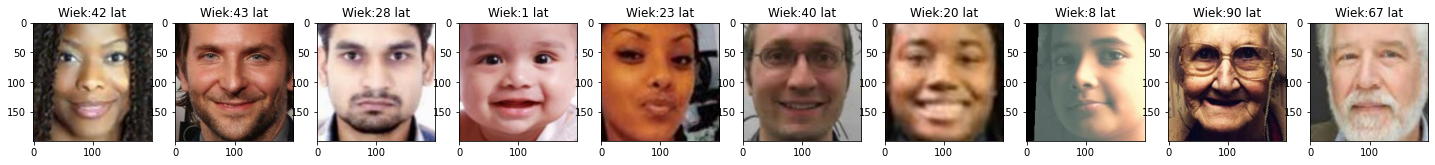

In [48]:
fig,axs=plt.subplots(1,10,figsize=(25,25))
for i in range(10):
    random_draw=df.sample(n=1)
    im_path=random_draw['file'].tolist()
    age=np.int_(random_draw['age']).tolist()
    im=cv2.imread('C:/Users/komej/Downloads/Faces/UTKFace/'+im_path[0])
    im=cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    axs[i].imshow(im)
    axs[i].set_title('Wiek:'+str(age[0])+' lat')

In [203]:
def conv_block(x_in,filters,k,s,bn=True):
    x=Conv2D(filters,kernel_size=(k,k),strides=s,padding='same',kernel_initializer='he_uniform',kernel_regularizer=l2(0.0001))(x_in)
    if bn:
        x=BatchNormalization()(x)
    x=Activation('relu')(x)
    return x
    
def build_model():
    inp=Input(shape=(200,200,3))
    x=conv_block(inp,64,5,1,bn=False)
    x=conv_block(x,64,5,2)
    x=conv_block(x,64,5,1)
    x=conv_block(x,128,4,2)
    x=conv_block(x,128,4,1)
    x=conv_block(x,256,3,2)
    x=conv_block(x,256,3,1)
    x=conv_block(x,512,3,2)
    x=conv_block(x,512,3,1)
    x=conv_block(x,1024,3,2)
    f=Flatten()(x)
    a=Dense(256,activation='relu',kernel_initializer='he_uniform')(f)
    a=Dropout(0.2)(a)
    a=Dense(1,activation='linear',name='age')(a)
    
    r=Dense(256,activation='relu',kernel_initializer='he_uniform')(f)
    r=Dropout(0.2)(r)
    r=Dense(5,activation='softmax',name='race')(r)
    
    g=Dense(256,activation='relu',kernel_initializer='he_uniform')(f)
    g=Dropout(0.2)(g)
    g=Dense(1,activation='sigmoid',name='gender')(g)
    model=Model(inp,[a,r,g])
    return model
    

In [204]:
model=build_model()

In [205]:
#Kompilacja sieci odpowiednimi funkcjami kosztu dla danych funkcji aktywacyjncyh
model.compile(optimizer=Adam(learning_rate=0.0001,decay=0.0001/1000),loss={'age':'mse','race':'categorical_crossentropy','gender':'binary_crossentropy'},loss_weights={'age':4.,'race':1.5,'gender':0.1},metrics={'age':'mae','race':'accuracy','gender':'accuracy'})

In [206]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 200, 200, 64) 4864        input_9[0][0]                    
__________________________________________________________________________________________________
activation_80 (Activation)      (None, 200, 200, 64) 0           conv2d_80[0][0]                  
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, 100, 100, 64) 102464      activation_80[0][0]              
____________________________________________________________________________________________

In [125]:
#Funkcja oparta na generatorze, której zadaniem jest wczytanie do pamięci zadaną ilość danych(zdjęć) do trenowania sieci.
def batch_gen(batch_size,df):
    while(1):
        half_path='C:/Users/komej/Downloads/Faces/UTKFace/'
        batches=df.sample(n=batch_size)
        files=batches['file']
        arr=[]
        for i in files:
            arr.append(i)
        age,gender,race=batches['age'], batches['gender'], batches['race']
        age=age/116
        race=to_categorical(race,5)
        org_images=[]
        for img in arr:
            img_train=cv2.imread(half_path+img)
            img_train=cv2.resize(img_train,(200,200))
            org_images.append(img_train)
        org_images=np.array(org_images)
        org_images=org_images.astype('float32')/255
        
        yield(org_images,[np.array(age,dtype='float32'),np.array(race),np.array(gender)])

In [126]:
#Funckja, która zwraca zbiór testowy aby sprawdzić dokładność sieci.
def test_gen(df):
    path='C:/Users/komej/Downloads/Faces/test/'
    files=df['file']
    arr=[]
    for i in files:
        arr.append(i)
    age,gender,race=df['age'],df['gender'],df['race']
    age=age/116
    race=to_categorical(race,5)
    org_images=[]
    for img in arr:
        img_train=cv2.imread(path+img)
        img_train=cv2.resize(img_train,(200,200))
        org_images.append(img_train)
    org_images=np.array(org_images)
    org_images=org_images.astype('float32')/255
    return(org_images,[np.array(age,dtype='float32'),np.array(race),np.array(gender,dtype='float32')])

In [127]:
batch_size=28
epochs=500
train_l,epoch_l,val=[],[],[]
accuracy_train,accuracy_test=[],[]
batches_processed_counter = 0
bat=batch_gen(batch_size,df)
img_test,labels_test=test_gen(df_test)
for e in range(1,epochs+1):
    batches_processed_counter +=1
    imgs,y=next(bat)
    model_loss,loss2,loss3,loss4,mae,accuracy_r,accuracy_g=model.train_on_batch(imgs,y)
    test_loss,loss2,loss3,loss4,test_mae,test_r,test_g=model.test_on_batch(img_test,labels_test)
    #tb.on_epoch_end(batches_processed_counter,{'train_loss':loss1,'train_acc':loss6})
    train_l.append(model_loss)
    epoch_l.append(e)
    val.append(test_loss)
    accuracy_train.append(accuracy_r)
    accuracy_test.append(test_r)
    print('Epoch:',e)
    print('Train loss:','main_loss:',model_loss,'MAE:',mae,'race_acc:',round(accuracy_r,3),'gender_acc:',round(accuracy_g,3))
    print('Test loss:','main_test_loss:',test_loss,'MAE:',test_mae,'race_acc:',round(test_r,3),'gender_acc:',round(test_g,3))
#tb.on_train_end(None)

Epoch: 1
Train loss: main_loss: 0.7072402238845825 MAE: 0.03425430506467819 race_acc: 0.964 gender_acc: 1.0
Test loss: main_test_loss: 0.8063980340957642 MAE: 0.04469626024365425 race_acc: 0.92 gender_acc: 1.0
Epoch: 2
Train loss: main_loss: 0.6713702082633972 MAE: 0.05199399217963219 race_acc: 1.0 gender_acc: 1.0
Test loss: main_test_loss: 0.7965431213378906 MAE: 0.04518258944153786 race_acc: 0.92 gender_acc: 1.0
Epoch: 3
Train loss: main_loss: 0.7391729354858398 MAE: 0.048099223524332047 race_acc: 1.0 gender_acc: 0.929
Test loss: main_test_loss: 0.7891020178794861 MAE: 0.04520973190665245 race_acc: 0.92 gender_acc: 1.0
Epoch: 4
Train loss: main_loss: 0.7044883966445923 MAE: 0.05112910643219948 race_acc: 1.0 gender_acc: 0.964
Test loss: main_test_loss: 0.7875049114227295 MAE: 0.04490939527750015 race_acc: 0.92 gender_acc: 1.0
Epoch: 5
Train loss: main_loss: 0.8173700571060181 MAE: 0.05881816893815994 race_acc: 1.0 gender_acc: 1.0
Test loss: main_test_loss: 0.7792894244194031 MAE: 0.04

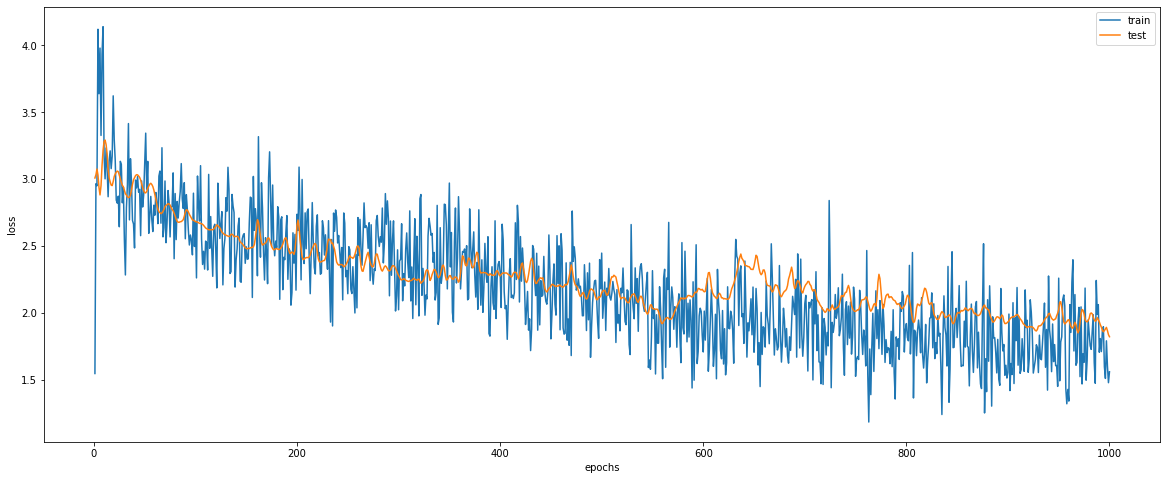

In [211]:
rcParams["figure.figsize"] = (20,8)
plt.plot(epoch_l,train_l,label='train')
plt.plot(epoch_l,val,label='test')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

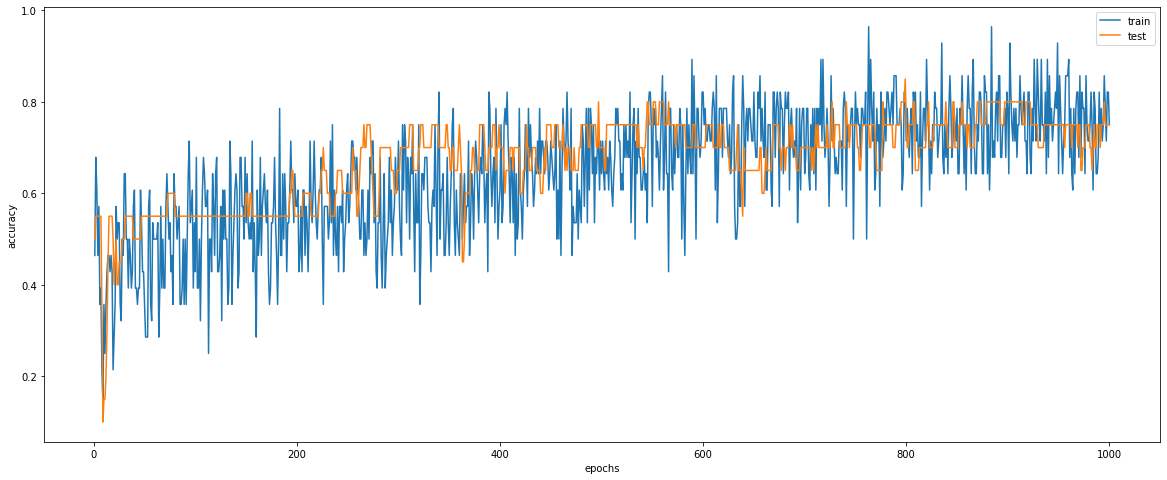

In [212]:
rcParams["figure.figsize"] = (20,8)
plt.plot(epoch_l,accuracy_train,label='train')
plt.plot(epoch_l,accuracy_test,label='test')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

In [55]:
def relative_squared_error(true, pred):
    true_mean = np.mean(true)
    squared_error_num=np.sum(np.square(true - pred))
    squared_error_den=np.sum(np.square(true - true_mean))
    rse = squared_error_num/squared_error_den
    return rse

In [18]:
def relative_root_mean_squared_error(true,pred):
    num=np.sum(np.square(true-pred))
    den=np.sum(np.square(pred))
    squared_error=num/den
    rrmse=np.sqrt(squared_error)
    return rrmse

In [94]:
#Ewaluacja modelu na zbiorze testowym
img_test,labels_test=test_gen(df_test)
score=model.predict(img_test)
s0=score[0]
#s0=np.reshape(s0,(-1))
labels_test[0]=labels_test[0].reshape(-1,1)
s1=score[1]
s2=np.round(score[2])
s2=s2.reshape(-1)

In [123]:
mae=tf.keras.metrics.mean_absolute_error(labels_test[0],s0).numpy()
mse=tf.keras.metrics.mean_squared_error(labels_test[0],s0).numpy()
rse=relative_squared_error(labels_test[0],s0)
rrmse=relative_root_mean_squared_error(labels_test[0],s0)
print('MAE:',round(np.sum(mae),3))
print('MSE:',round(np.sum(mse),3))
print('RMSE:',round(np.sqrt(np.sum(mse)),3))
print('RSE:',round(rse,3))
print('RRMSE:',round(rrmse*100,1),'%')

MAE: 1.053
MSE: 0.069
RMSE: 0.263
RSE: 0.082
RRMSE: 15.6 %


In [128]:
print('Średnia dla etykiet:',np.mean(labels_test[0]),'Średnia dla wyników:',np.mean(s0))

Średnia dla etykiet: 0.27655172 Średnia dla wyników: 0.28599012


In [129]:
print('Odchylenie Standardowe dla etykiet:',np.std(labels_test[0]),'Odchylenie Standardowe dla wyników:',np.std(s0))

Odchylenie Standardowe dla etykiet: 0.19310221 Odchylenie Standardowe dla wyników: 0.17970966


W przypadku szacowania wieku wyniki są całkiem dobre, pomimo pewnych pomyłek. Wartości MAE,MSE i RMSE są całkiem przyzwoite oraz RSE. Wartość RRMSE wynosi 15% co tez jest oznaką dobrze działającego modelu.

In [58]:
gender_accuracy=accuracy_score(labels_test[2],s2)
gender_recall=recall_score(labels_test[2],s2)
gender_precision=precision_score(labels_test[2],s2)
gender_fscore=f1_score(labels_test[2],s2)
print('Dokładność:',round(gender_accuracy,3),'%')
print('Czułość:',round(gender_recall,3)*100,'%')
print('Precyzja:',round(gender_precision,3)*100,'%')
print('F1-score:',round(gender_fscore,3)*100,'%')

Dokładność: 0.96 %
Czułość: 100.0 %
Precyzja: 91.7 %
F1-score: 95.7 %


Określanie płci również osiąga bardzo dobre wyniki sięgające 96% dokładności na zbiorze testowym. Czułość sięga 100% oraz precyzja blisko 92% mają one bardzo wysokie wartości. Średnia harmoniczna(F-score) wynosi 96%.

In [59]:
for v in range(len(s1)):
    ind=np.argmax(s1[v])
    s1[v,ind]=1
s1=np.round(s1)
accuracy_race=accuracy_score(labels_test[1],s1)
recall_race=recall_score(labels_test[1],s1,labels=[0,1,2,4],average='micro')
precision_race=precision_score(labels_test[1],s1,labels=[0,1,2,4],average='micro')
race_fscore=f1_score(labels_test[1],s1,labels=[0,1,2,4],average='micro')
print('Dokładność:',round(accuracy_race,3)*100,'%')
print('Czułość:',round(recall_race,3)*100,'%')
print('Precyzja:',round(precision_race,3)*100,'%')
print('F1-score:',round(race_fscore,3)*100,'%')

Dokładność: 88.0 %
Czułość: 90.5 %
Precyzja: 86.4 %
F1-score: 88.4 %


Dla określania rasy w tym przypadku pięciu klas, dokładność jest nieco gorsza wynosząca 88%. Czułość i precyzja również osiągają zadowalajace wyniki.

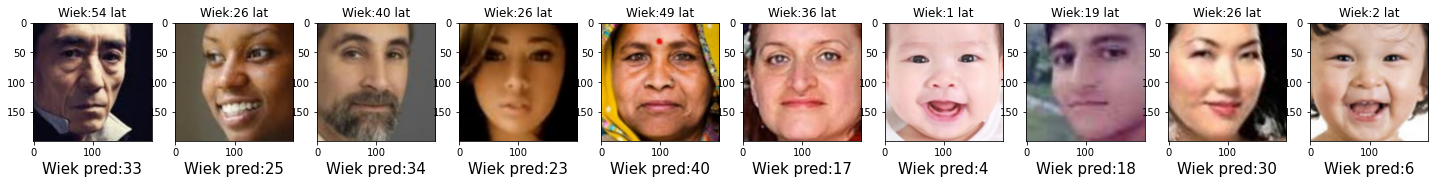

In [80]:
fig,axs=plt.subplots(1,10,figsize=(25,25))
for i in range(10):
    random_draw=df_test.sample(n=1)
    im_path=random_draw['file'].tolist()
    age=np.int_(random_draw['age']).tolist()
    im=cv2.imread('C:/Users/komej/Downloads/Faces/test/'+im_path[0])
    im=cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    img=np.expand_dims(im,axis=0)
    score=model.predict(img/255)
    score[0]=score[0].reshape(-1)[0]*116
    axs[i].imshow(im)
    axs[i].set_title('Wiek:'+str(age[0])+' lat')
    axs[i].set_xlabel('Wiek pred:'+str(round(score[0])),size=15)

Zwizualizowanie wieku prawdziwego oraz tego przewidzianego przez model. Jak widać model troche się myli, najwięcej w przypadku wieku poniżej 15. 

In [98]:
model.save('C:/Users/komej/Downloads/Faces/fac6.h5')